# Portfolio Project 2 - Wine

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, normalize

from sklearn.covariance import EllipticEnvelope

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Business Justification

A wine maker wants to know what makes a wine good or bad using samples analysed in a lab. They want to be able to predict whether a wine is good or bad based on its physical properties (pH, etc). They therefore get a lab to analyse a load of different wines and use this data to create a dataset that includes a quality rating for each sample. They want a machine learning model drawn up that has a workable accuracy to make these predictions.

## Modus Operandi

I will treat this as a classification problem. I will factorise model creation, operation, and printing their results. I will cast a wide net by using a variety of models to see how data and feature engineering techniques impact model performance [in this case taken to be accuracy score for its interpretability.] This will be an iterative process with a view to increasing accuracy.

## 1. Obtain a Dataset.

We need data to work with. This dataset is located at https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009.

### 1a. Data Examination and Preparation

Before we work with the data, we'll need to make sure the rows contain valid data. To do this we'll need to first examine the data.

In [3]:
wine = pd.read_csv('winequality-red.csv')
df = pd.DataFrame(wine)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# check for null values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
df.rename(columns={'fixed acidity': 'fixed_acidity',
                   'volatile acidity': 'volatile_acidity',
                   'citric acid':'citric_acid',
                   'residual sugar':'residual_sugar',
                   'free sulfur dioxide':'free_sulfur_dioxide',
                   'total sulfur dioxide':'total_sulfur_dioxide'}, inplace=True)

### 1b. Remove Duplicates

It seems to me that if you want to make broad and lasting changes to the dataset, the best time to do that is now. For instance, our dataset may contain duplicate entries. We might not want duplicate entries because that might introduce bias to our model around these date points. 


Let's create a function to remove the duplicates.

In [7]:
# remove duplicates
# this might seem like overengineering but at the end of the day it'll be easier to remember a bunch of generic functions
# than object methods

def remove_duplicates(dataframe):
    return dataframe.drop_duplicates()

### 1c. Scale the Data

I would say that scaling the data is quite a broad change. We won't perform the actual scaling here but will keep the function here for simplicitys sake.

In [8]:
standard_scaler = StandardScaler()

In [9]:
# function to get our x train and test data, scale it and return it
# we don't scale y because y is our labels/the classes we are predicting to

def scale_data(x_train, x_test):
    
    x_train = standard_scaler.fit_transform(x_train)
    x_test = standard_scaler.fit_transform(x_test)
    
    return x_train, x_test

## 2. Model Drafting

Let's facilitate getting programmatical representations of our independent and dependent variables, also known as x and y.

In [10]:
def get_xy_vars(dataframe):
    
    # turn dataframe into x and y
    # y is last column of dataframe
    x=dataframe.iloc[:,0:-1]
    y=dataframe.iloc[:,-1]
    
    return x, y

# Let's try a more functional version which takes accomodates optional arguments.
# this is overengineered for a single column, but will work with more complex models

def get_xy_vars(dataframe, columns):
    
    x = dataframe.drop(columns, axis=1)
    y_list = [dataframe[[col]] for col in columns]
    y = pd.concat(y_list, axis=1)
    
    return x, y

In [11]:
# factorise displaying classification model results

def print_classification_models_results(model_names_list, model_list, x_train, y_train, x_test, y_test):
    
    print('Classification Models:')
    for i in range(len(model_list)):
        try:
            print(model_names_list[i])
            print(model_list[i].score(x_train, y_train), model_list[i].score(x_test, y_test))
            print(f'Accuracy score: {round(accuracy_score(y_test, model_list[i].predict(x_test)) * 100, 2)}%', '\n')
        except ValueError as e:
            print('\n')

In [12]:
# we can use cross validation to prevent overfitting on our decision tree based models

def print_cross_val_model_results(model_names_list, model_list, x, y, k, x_train, y_train, x_test, y_test):

    print('Models using K-Fold Cross Validation:')
    for i in range(len(model_list)):
        kf = KFold(n_splits=k, random_state=None)
        print(model_names_list[i])
        print(cross_val_score(model_list[i], x, y, cv = kf), '\n')

In [13]:
# let's make a function that runs a given dataset through a variety of models and prints the results
# this saves us copy and pasting a million cells to get a ballpark figure of how well models handle our data

# I have parameterised the random forest models to prevent overfitting, this was done after the fact but their
# accuracy did improve

def model_draft(dataframe, split, ran_state):
    
    # remove duplicates
    # df = remove_duplicates(dataframe)
    
    x, y = get_xy_vars(dataframe, ['quality'])
    y = y.values.ravel()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=ran_state)
    x_train, x_test, = scale_data(x_train, x_test)
    
    # logistic regression and naive bayes
    log_reg_model = LogisticRegression(solver='liblinear', random_state = 42).fit(x_train, y_train)
    gn_model = GaussianNB().fit(x_train, y_train)
    
    # decision tree and ensemble models
    dtc_model = tree.DecisionTreeClassifier().fit(x_train, y_train)
    rfc_model = RandomForestClassifier(n_estimators=100, max_features=3, max_depth=10, random_state=100).fit(x_train, y_train)
    gbc_model = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1).fit(x_train, y_train)
    bc_model = BaggingClassifier(estimator=RandomForestClassifier(), random_state=0).fit(x_train, y_train)
    
    # svm
    svc_model = SVC().fit(x_train, y_train)
    
    #classification model list
    class_model_names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Decision Tree Classifier',
                      'Random Forest Classifier', 'Gradient Boosting Classifier', 'Support Vector Classifier', 
                         'Bagging Classifier']
    class_model_list = [log_reg_model, gn_model, dtc_model, rfc_model, gbc_model, svc_model, bc_model]
    
    # cross val models list
    cross_val_model_names = ['Decision Tree Classifier', 'Random Forest Classifier']
    cross_val_models = [dtc_model, rfc_model]
    
    #clustering
    knn_model = KNeighborsClassifier(n_neighbors=10).fit(x_train,y_train)
    
    #print results
    print_classification_models_results(class_model_names, class_model_list, x_train, y_train, x_test, y_test)
    print_cross_val_model_results(cross_val_model_names, cross_val_models, x, y, 5, x_train, y_train, x_test, y_test)

    print('Clustering models: ')
    print(f'K-Nearest Neighbour Classifier Model Score: {knn_model.score(x_train, y_train), knn_model.score(x_test, y_test)}')

In [14]:
model_draft(df, 0.3, 100)

Classification Models:
Logistic Regression
0.6085790884718498 0.59375
Accuracy score: 59.38% 

Gaussian Naive Bayes
0.5647899910634495 0.5375
Accuracy score: 53.75% 

Decision Tree Classifier
1.0 0.55
Accuracy score: 55.0% 

Random Forest Classifier
0.968722073279714 0.6583333333333333
Accuracy score: 65.83% 

Gradient Boosting Classifier
0.644325290437891 0.6
Accuracy score: 60.0% 

Support Vector Classifier
0.675603217158177 0.6354166666666666
Accuracy score: 63.54% 

Bagging Classifier
0.9624664879356568 0.6479166666666667
Accuracy score: 64.79% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.48125    0.48125    0.428125   0.434375   0.52351097] 

Random Forest Classifier
[0.603125   0.53125    0.59375    0.565625   0.59561129] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.6595174262734584, 0.5729166666666666)


Now we have an idea of how our models are performing, we can try and optimise them. The first method we will use is to remove outliers.

## 3. Clean Data

Let's clean our data. First we'll check for missing values.

In [15]:
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Our data has no missing values, since there are no null values.

Let's see how the targets - values in the ```quality``` column - are distributed.

In [16]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

As we can see, most of the rows in our data have a quality of 5.0 and 6.0. Let's structure these values in human terms so we can understand them better.

In [17]:
threes = 5
fours = 42
fives = 566
sixes = 554
sevens = 159
eights = 11

This gives us an idea of how people are likely to judge wines. They are apparently drinking variations on the Portuguese "Vinho Verde" wine. A quick google tells me that the Portugese are the biggest wine drinkers in the world per capita (https://www.therealreview.com/2022/08/04/top-ten-wine-consumers/). 

Let's make a trial dataset of the best represented data and see how it runs.

### 3a. Normalise the Dataset

In [18]:
# remove rows containing one of list of values
counts = df['quality'].value_counts()

counts = df['quality'].value_counts().tolist()
indexes = df['quality'].value_counts().index.tolist()

data_distro = [(count, idx) for count, idx in zip(counts, indexes)]
data_distro

[(681, 5), (638, 6), (199, 7), (53, 4), (18, 8), (10, 3)]

So we have 681 rows of data about wine with a quality of 5, 638 for 6, etc.

We only have 10 datapoints for wines with a quality of 3, 18 for a quality of 8, etc. This is the data we are using to train our model, so while by using it we may be able to predict a greater range of values, it doesn't have too much to go on. What's more likely is that these underrepresented targets ['quality' column in the dataframe] will interfere with our models ability to predict targets for data which it does have. So rather than broadening the scope of what our model will predict, the outlier data interferes with its ability to predict based on what it does know. 

We can't use underrepresented targets in our dataset. But we can deal with them in different ways.

Firstly, we can take every row with a quality value of less than 5 or greater than 6 and round to those numbers respectively. This is basically a way of just saying wines in those categories are either good or bad, which is fair. This might help our model to predict things.   

The second way is to simply use the best two represented targets/labels. This allows us to treat the problem as a classification one. 

Both of these approaches are valid, and we will see how either one affects our accuracy.

#### Approximate Quality to Good or Bad

Let's go through our dataset, find the rows with a quality that isn't 5 or 6, and round them to 5 or 6 respectively.

In [19]:
def approximate_quality_values(dataframe):
    
    # iterate through every row of our dataframe, round quality values to good or bad
    for (idx, row) in dataframe.iterrows():
        if row.loc['quality'] < 5:
            row.loc['quality'] = 5.0
        elif row.loc['quality'] > 6:
            row.loc['quality'] = 6.0
    return dataframe
        
inclusive_df = approximate_quality_values(df)

In [20]:
model_draft(inclusive_df, 0.3, 100)

Classification Models:
Logistic Regression
0.6085790884718498 0.59375
Accuracy score: 59.38% 

Gaussian Naive Bayes
0.5647899910634495 0.5375
Accuracy score: 53.75% 

Decision Tree Classifier
1.0 0.5645833333333333
Accuracy score: 56.46% 

Random Forest Classifier
0.968722073279714 0.6583333333333333
Accuracy score: 65.83% 

Gradient Boosting Classifier
0.644325290437891 0.6
Accuracy score: 60.0% 

Support Vector Classifier
0.675603217158177 0.6354166666666666
Accuracy score: 63.54% 

Bagging Classifier
0.9624664879356568 0.6479166666666667
Accuracy score: 64.79% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.509375   0.4625     0.4        0.403125   0.52351097] 

Random Forest Classifier
[0.603125   0.53125    0.59375    0.565625   0.59561129] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.6595174262734584, 0.5729166666666666)


Doesn't seem to have changed much. 

### Normalising the Dataset by Representation

Let's try removing the underrepresented datapoints from our dataset.

In [21]:
fives = df.loc[df['quality'] == 5]
sixes = df.loc[df['quality'] == 6]

# we might use sevens, we might not
sevens = df.loc[df['quality'] == 7]
len(fives), len(sixes), len(sevens)

(681, 638, 199)

Let's create an empty copy of our dataset and concatenate our data subsets with it.

In [22]:
main_df = pd.DataFrame()

In [23]:
main_df = pd.concat([main_df, fives], axis=0)
main_df = pd.concat([main_df, sixes], axis=0)
main_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.62,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1595,5.9,0.55,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6


In [24]:
# reset the annoying indexes and remove them

main_df = main_df.reset_index(drop=True)

In [25]:
model_draft(main_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7085590465872156 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.6868905742145178 0.7348484848484849
Accuracy score: 73.48% 

Decision Tree Classifier
1.0 0.6767676767676768
Accuracy score: 67.68% 

Random Forest Classifier
0.9880823401950163 0.7777777777777778
Accuracy score: 77.78% 

Gradient Boosting Classifier
0.7280606717226435 0.76010101010101
Accuracy score: 76.01% 

Support Vector Classifier
0.7562296858071506 0.7702020202020202
Accuracy score: 77.02% 

Bagging Classifier
0.971830985915493 0.7752525252525253
Accuracy score: 77.53% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.46212121 0.46212121 0.45075758 0.49242424 0.40304183] 

Random Forest Classifier
[0.45833333 0.4469697  0.5        0.36363636 0.44486692] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7291440953412784, 0.7247474747474747)


Looks pretty good! Let's try a copy of the dataset without duplicate rows:

In [26]:
main_df_no_dupes = remove_duplicates(main_df)
model_draft(main_df_no_dupes, 0.3, 100)

Classification Models:
Logistic Regression
0.7223650385604113 0.7005988023952096
Accuracy score: 70.06% 

Gaussian Naive Bayes
0.6940874035989717 0.6946107784431138
Accuracy score: 69.46% 

Decision Tree Classifier
1.0 0.6706586826347305
Accuracy score: 67.07% 

Random Forest Classifier
0.9781491002570694 0.7305389221556886
Accuracy score: 73.05% 

Gradient Boosting Classifier
0.7365038560411311 0.7065868263473054
Accuracy score: 70.66% 

Support Vector Classifier
0.7724935732647815 0.6706586826347305
Accuracy score: 67.07% 

Bagging Classifier
0.9511568123393316 0.718562874251497
Accuracy score: 71.86% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.47533632 0.47982063 0.5045045  0.37387387 0.40990991] 

Random Forest Classifier
[0.48430493 0.42600897 0.52252252 0.35135135 0.46846847] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7699228791773779, 0.6616766467065869)


Our accuracy went down after removing duplicates. But the duplicate data points might represent original data. For example, these data points might represent different wines - we have no way of telling. Our accuracy on the test set was better with the duplicates, so let's keep them in for the time being.

### 3b. Feature Selection by Low Variance

Features with minimal variance are almost in the same ballpark as constants, features with no variance - Let's have a look at our features and try removing those with a very low variance. This is also known as a Low Variance Filter.

In [27]:
new_df = main_df

In [28]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
chlorides                  0.002260
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
density                    0.000003
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [29]:
# remove columns with low variance, like density, maybe chlorides
new_df = new_df.drop('density', axis=1)

In [30]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
chlorides                  0.002260
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [31]:
model_draft(new_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7118093174431203 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7171717171717171
Accuracy score: 71.72% 

Decision Tree Classifier
1.0 0.7171717171717171
Accuracy score: 71.72% 

Random Forest Classifier
0.9859154929577465 0.7651515151515151
Accuracy score: 76.52% 

Gradient Boosting Classifier
0.7302275189599133 0.7424242424242424
Accuracy score: 74.24% 

Support Vector Classifier
0.7540628385698809 0.7651515151515151
Accuracy score: 76.52% 

Bagging Classifier
0.9761646803900325 0.7727272727272727
Accuracy score: 77.27% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.46969697 0.48106061 0.41666667 0.48106061 0.5095057 ] 

Random Forest Classifier
[0.48106061 0.49621212 0.5        0.39772727 0.42205323] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7367280606717227, 0.702020202020202)


In [32]:
new_df = new_df.drop('chlorides', axis=1)

In [33]:
model_draft(new_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7085590465872156 0.7323232323232324
Accuracy score: 73.23% 

Gaussian Naive Bayes
0.6890574214517876 0.7095959595959596
Accuracy score: 70.96% 

Decision Tree Classifier
1.0 0.7095959595959596
Accuracy score: 70.96% 

Random Forest Classifier
0.9837486457204767 0.76010101010101
Accuracy score: 76.01% 

Gradient Boosting Classifier
0.7172264355362947 0.7247474747474747
Accuracy score: 72.47% 

Support Vector Classifier
0.752979414951246 0.76010101010101
Accuracy score: 76.01% 

Bagging Classifier
0.9739978331527628 0.7727272727272727
Accuracy score: 77.27% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.45075758 0.45454545 0.46590909 0.43939394 0.50190114] 

Random Forest Classifier
[0.45454545 0.4469697  0.56060606 0.38257576 0.44106464] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7215601300108342, 0.702020202020202)


I'm not sure our model has improved, but we did get a jump in accuracy after dropping a second column. Let's try dropping a third and see how our model looks.

In [34]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [35]:
new_df = new_df.drop('pH', axis=1)

In [36]:
model_draft(new_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7107258938244854 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7070707070707071
Accuracy score: 70.71% 

Decision Tree Classifier
1.0 0.6792929292929293
Accuracy score: 67.93% 

Random Forest Classifier
0.9837486457204767 0.7575757575757576
Accuracy score: 75.76% 

Gradient Boosting Classifier
0.7226435536294691 0.7247474747474747
Accuracy score: 72.47% 

Support Vector Classifier
0.7464788732394366 0.7575757575757576
Accuracy score: 75.76% 

Bagging Classifier
0.980498374864572 0.7626262626262627
Accuracy score: 76.26% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.47727273 0.50757576 0.52651515 0.47348485 0.43346008] 

Random Forest Classifier
[0.46969697 0.48484848 0.56439394 0.40530303 0.47148289] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7443120260021668, 0.7196969696969697)


### Was Low Variance Filter a Suitable Feature Engineering Technique?

No. We'll go back to using ```main_df``` and try some more stuff.

### 3b.  Remove Outliers

Let's visualise our data to see if we have any outliers.

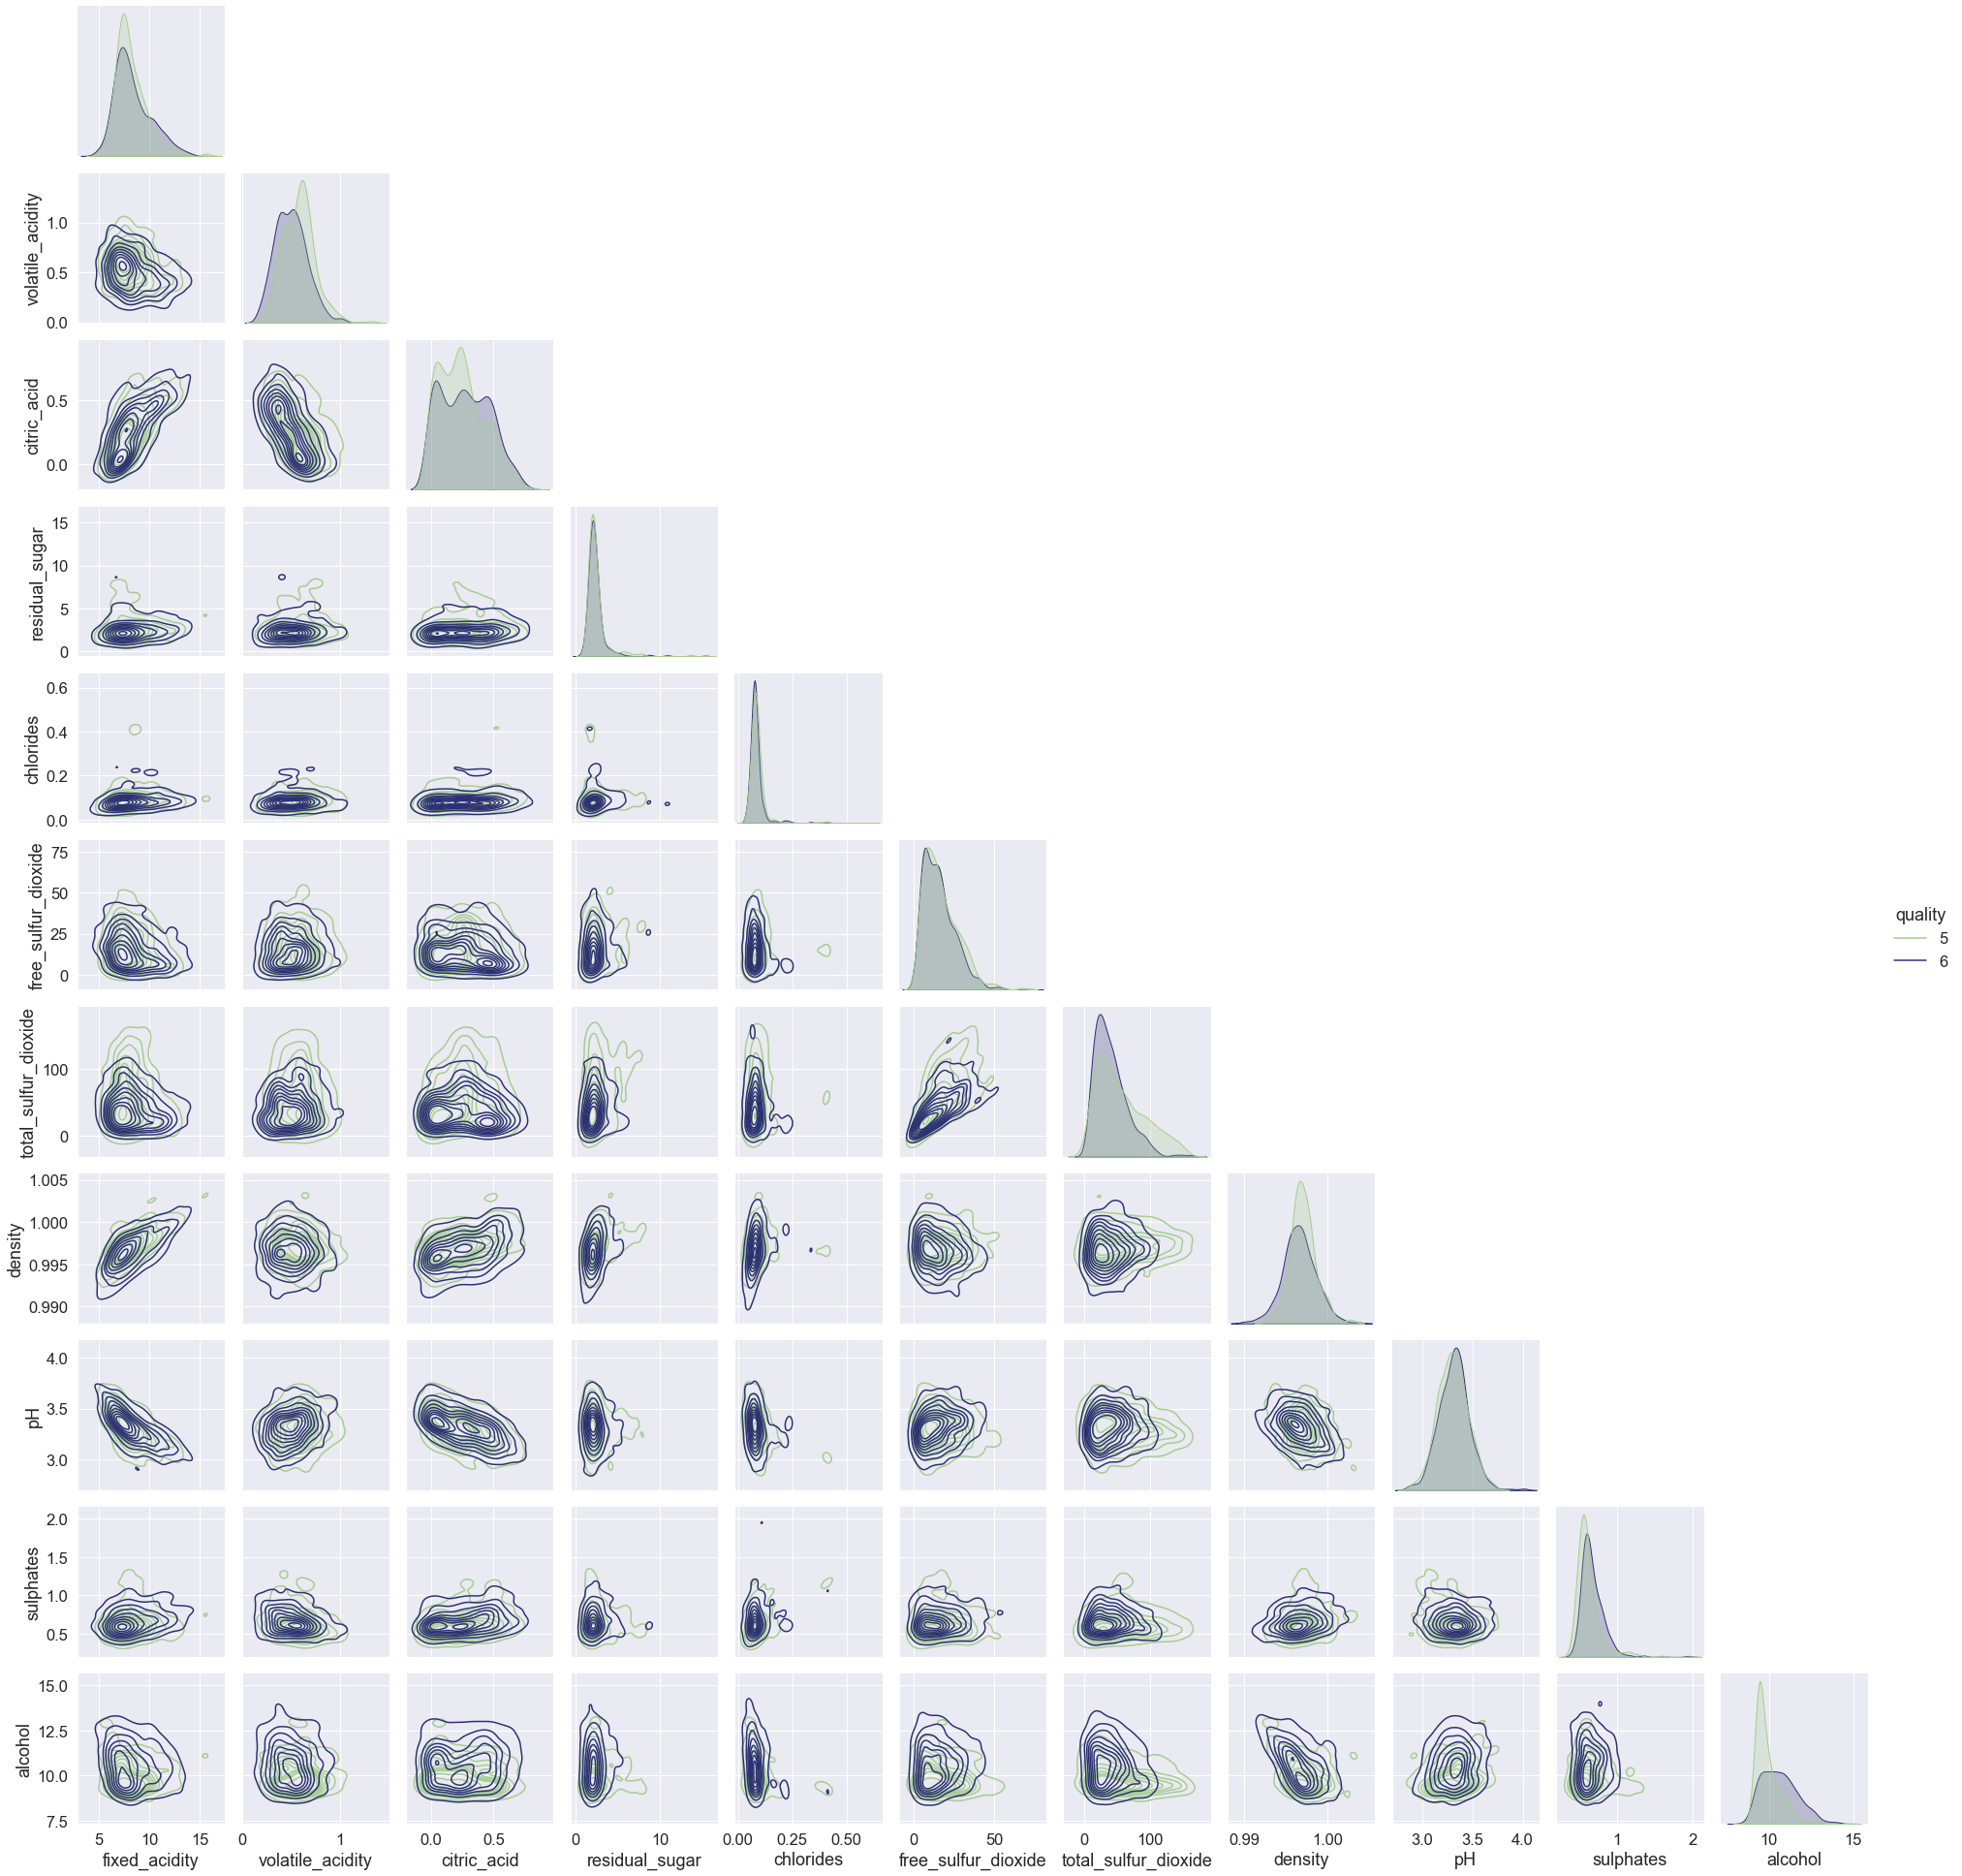

In [37]:
sns.set(font_scale=1.5)
sns.pairplot(main_df, hue='quality', kind='kde', corner=True, palette='crest')

We do, but the figures are rather smol. Let's right click the image, open it in a new tab and left click on it to magnify. The diagonals represent how that feature relates to 'quality'. The two qualities are coloured differently (green is 5, or 'bad'). So wines with a 'bad' quality are more likely to have a higher fixed acidity, whereas if we scroll to the bottom, we see wines with a higher alcohol content are more lilely to be of 'good' quality. 

The non-diagonals are KDE charts (Kernel Density Estimation). These are basically clusters, where the inmost section represents the highest concentration of data points, and the outermost section represents the lowest concentrations of data points. As we can see, there are a number of outliers in our dataset represented by small kernels located independently of the main ones. Let's put a function together to remove them and see how it affects our model accuracy.

For this we will use the **Sigma 3 Rule**. This states that 68% of data points fall within the first standard deviation from the mean, 95% fall within the second, and 99.7% within the third.

For this then we need to calculate the mean and standard deviation for each feature/column/predictor variable. Then we can remove rows containing values that fall outside a given number of deviations.

In [38]:
# let's calculate the mean of each column

def get_column_means(dataframe):
    means = []
    for i in range(len(df.columns)):
        means.append(np.mean(dataframe.iloc[:, i]))
    return np.array(means)
        
print(get_column_means(main_df))

[ 8.25428355  0.53855951  0.25826384  2.50386657  0.08897271 16.36846096
 48.94692949  0.99686731  3.31129644  0.64726308 10.2527167   5.48369977]


In [39]:
# and its standard deviation

def get_column_deviations(dataframe):
    deviations = []
    for i in range(len(df.columns)):
        deviations.append(np.std(dataframe.iloc[:, i]))
    return np.array(deviations)
        
print(get_column_deviations(main_df))

[1.68229718e+00 1.67615424e-01 1.87923339e-01 1.39910219e+00
 4.75196222e-02 1.04883570e+01 3.27016261e+01 1.81446553e-03
 1.52286797e-01 1.67270420e-01 9.71985008e-01 4.99734232e-01]


In [40]:
def get_inliers(dataframe, within_std, col_names_to_exclude=[None]):
    
    # no_of_std is the number of standard deviations a cell value can lie within before the row is counted as an outlier.
    # for instance, dataframe = [1, 2, 2, 4]
    # mean is 9/4 = 2.25
    # deviation is numerical distance from the mean
    # standard deviation is the sum of the square root of a collections deviations from the mean
    # deviations from 1 standard deviation are: 1.25, .25, .25, 1.75
    # standard deviations squares these and sums them
    
    # within_std can take a float
    # col_names_to_exclude is presumably a list of targets
    
    # get means and deviations 
    means = get_column_means(dataframe)
    deviations = get_column_deviations(dataframe)
    
    inliers_df = pd.DataFrame(columns=dataframe.columns)
    outliers_df = pd.DataFrame(columns=dataframe.columns)
    
    # iterate through every row of our dataframe
    for row in dataframe.iterrows():
        
        # we then iterate through each column of the row
        # we could use for i in range(len(means)) but it's less explicit
        
        for i in range(len(dataframe.columns)):
            
            # skip current column if its in list of column names to exclude
            if dataframe.columns[i] in col_names_to_exclude:
                break
            
            inlier = True
            
            # according to the sigma 3 rule, 95% of datapoints fall within first two standard deviations
            # we therefore create upper and lower bounds representing column mean minus or plus 2 * std
            lower_bound = means[i] - within_std * deviations[i]
            upper_bound = means[i] + within_std * deviations[i]
            
            # get value of current cell
            # row[0] contains the index, row[1] contains the data... we can access each row cell with row[1][i]
            cell_value = row[1][i]
            
            if cell_value >= lower_bound and cell_value <= upper_bound:
                continue
            else:
                inlier = False
                break
        
        # convert row to dataframe, retain structure
        row_as_df = pd.DataFrame(row[1]).transpose()
        
        if inlier:
            inliers_df = pd.concat([inliers_df, row_as_df], axis=0)
        if not inlier:
            outliers_df = pd.concat([outliers_df, row_as_df], axis=0)
        
    return inliers_df, outliers_df

Now we have a function that takes a dataframe, a standard deviation filter, and a list of column names we can exclude from operating on. The 'standard deviation filter' is just a coefficient we can use to determine if a feature value is an outlier. The lower and upper limits are basically ```mean - (std * std_filter)``` and ```mean + (std * std_filter)```. 

Pretty simple! Let's use our function, remove outliers and visualise our data.

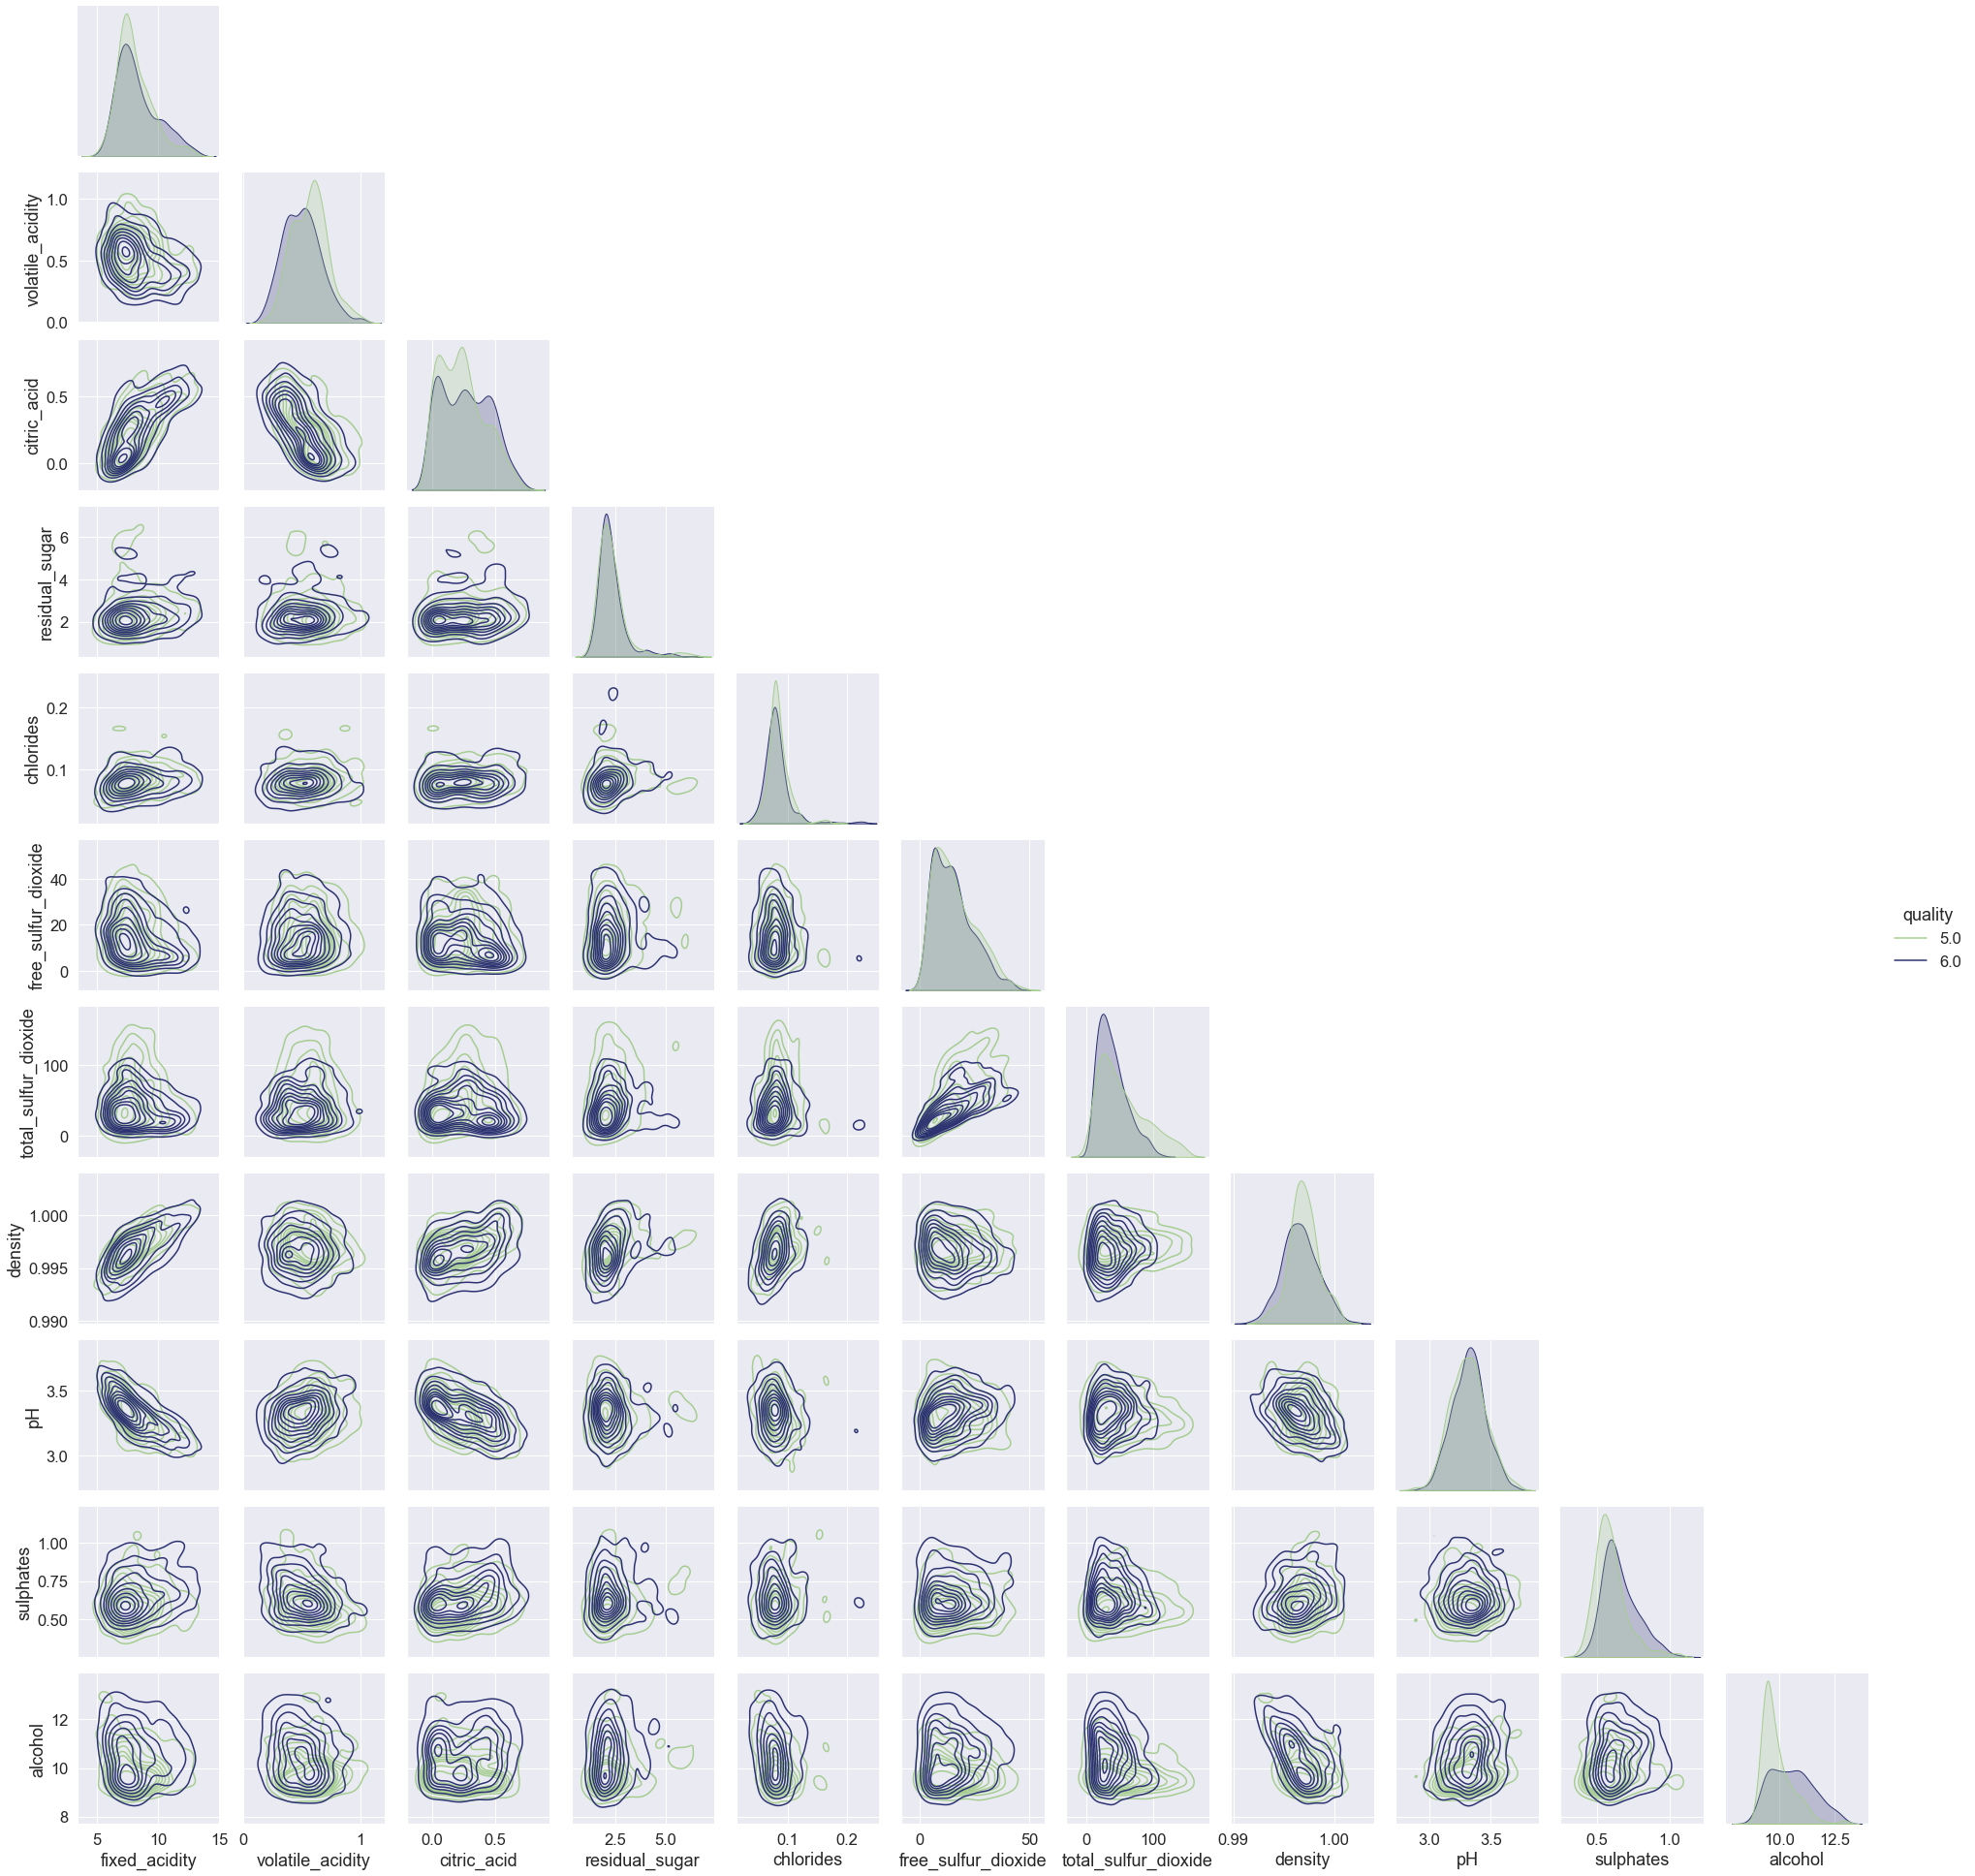

In [41]:
inliers, outliers = get_inliers(main_df, 3)
inliers = inliers.astype('float64')
sns.pairplot(inliers, hue='quality', kind='kde', corner=True, palette='crest')

Our data looks more uniform and regular. Let's see how the dataset performs with ```model_draft```.

In [42]:
model_draft(inliers, 0.3, 100)

Classification Models:
Logistic Regression
0.7234803337306317 0.7388888888888889
Accuracy score: 73.89% 

Gaussian Naive Bayes
0.7020262216924911 0.7
Accuracy score: 70.0% 

Decision Tree Classifier
1.0 0.7027777777777777
Accuracy score: 70.28% 

Random Forest Classifier
0.9868891537544696 0.7583333333333333
Accuracy score: 75.83% 

Gradient Boosting Classifier
0.768772348033373 0.7
Accuracy score: 70.0% 

Support Vector Classifier
0.7878426698450537 0.7444444444444445
Accuracy score: 74.44% 

Bagging Classifier
0.9690107270560191 0.7694444444444445
Accuracy score: 76.94% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.54166667 0.425      0.47916667 0.41666667 0.38912134] 

Random Forest Classifier
[0.45       0.45416667 0.5        0.3875     0.39748954] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7651966626936829, 0.7138888888888889)


Our accuracy hasn't gone up. That's ok. Let's try a list of deviation values and see if our results improve.

In [43]:
deviations = [1.5, 2, 2.5, 3, 3.5]

for deviation in deviations:
    
    print('\nCurrent standard deviation is: ', str(deviation), '\n')
    inliers, outliers = get_inliers(main_df, deviation)
    inliers = inliers.astype('float64')
    model_draft(inliers, 0.3, 100)


Current standard deviation is:  1.5 

Classification Models:
Logistic Regression
0.6919431279620853 0.6740331491712708
Accuracy score: 67.4% 

Gaussian Naive Bayes
0.6800947867298578 0.7071823204419889
Accuracy score: 70.72% 

Decision Tree Classifier
1.0 0.6685082872928176
Accuracy score: 66.85% 

Random Forest Classifier
1.0 0.7292817679558011
Accuracy score: 72.93% 

Gradient Boosting Classifier
0.7109004739336493 0.6850828729281768
Accuracy score: 68.51% 

Support Vector Classifier
0.8080568720379147 0.6906077348066298
Accuracy score: 69.06% 

Bagging Classifier
0.9739336492890995 0.7403314917127072
Accuracy score: 74.03% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.43801653 0.50413223 0.50413223 0.31666667 0.43333333] 

Random Forest Classifier
[0.33884298 0.43801653 0.39669421 0.29166667 0.325     ] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7345971563981043, 0.6795580110497238)

Current standard deviation is:  2 

Classification 

Implementing the Sigma-3 Rule didn't help, but I think was worth trying.

## 4. Data Exploration

Now we've cleaned our data and tried removing outliers - including rows containing underrepesented values - we can explore the data. First let's look for **colinearities**. Colinearities occur where two or more predictor variables/features are closely correlated. This can make it difficult to predict one value from the other. Though they are mostly a problem in regression models, they can also impact our ability to understand classification ones.

### 4a. Calculate Colinearities using Variance Inflation Factor

Variance Inflation Factor is a metric that tells us how closely correlated features are. The higher the VIF, the higher the correlation. It tells us how much a variable is contributing to the standard error in regression-based calculations. When there are big multicolinearity issues, VIF values will be big to reflect that. 

When we have identified these values, we can eliminate or combine collinear variables to solve multicolinearity.

Let's take a look at our dataset's VIF values.

In [44]:
vif_df = main_df

In [45]:
def get_vif(dataframe):
    for i in range(len(dataframe.columns)):
        print(dataframe.columns[i], variance_inflation_factor(dataframe, i))

get_vif(vif_df)

# do i include target column when inspecting VIF?

fixed_acidity 74.44453944963715
volatile_acidity 19.156420361962585
citric_acid 8.336203370140614
residual_sugar 4.6464684441807425
chlorides 6.516765283007158
free_sulfur_dioxide 6.956396879041938
total_sulfur_dioxide 7.3469064528397245
density 1557.7948984498641
pH 1053.794558621151
sulphates 21.274284711569145
alcohol 149.5585721589109
quality 156.94464591107752


Let's take out the column with the highest VIF and see how that impacts the VIF of the rest of the columns:

In [46]:
vif_df = vif_df.drop('density', axis=1)
get_vif(new_df)

fixed_acidity 42.65211348899319
volatile_acidity 15.956597613365366
citric_acid 7.719417405783541
residual_sugar 4.634718671213499
free_sulfur_dioxide 6.879821464065353
total_sulfur_dioxide 6.5709225951414965
sulphates 17.599482866630204
alcohol 101.69482249014206
quality 115.82391191281138


In [47]:
model_draft(vif_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7118093174431203 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7171717171717171
Accuracy score: 71.72% 

Decision Tree Classifier
1.0 0.7070707070707071
Accuracy score: 70.71% 

Random Forest Classifier
0.9859154929577465 0.7651515151515151
Accuracy score: 76.52% 

Gradient Boosting Classifier
0.7302275189599133 0.7424242424242424
Accuracy score: 74.24% 

Support Vector Classifier
0.7540628385698809 0.7651515151515151
Accuracy score: 76.52% 

Bagging Classifier
0.9761646803900325 0.7727272727272727
Accuracy score: 77.27% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.46212121 0.45454545 0.43560606 0.4469697  0.45627376] 

Random Forest Classifier
[0.48106061 0.49621212 0.5        0.39772727 0.42205323] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7367280606717227, 0.702020202020202)


In [48]:
get_vif(vif_df)

fixed_acidity 43.016875726028154
volatile_acidity 19.112206480769228
citric_acid 8.3056340650316
residual_sugar 4.64622550939642
chlorides 5.973098817718006
free_sulfur_dioxide 6.884483022134156
total_sulfur_dioxide 6.778606527448602
pH 207.1648211686496
sulphates 21.26974152544324
alcohol 148.93998084726744
quality 148.23924502397404


Wow! That appears to have helped a lot in regards to VIF (not so much accuracy). Let's try another column

In [49]:
vif_df = vif_df.drop('pH', axis=1)
get_vif(vif_df)

fixed_acidity 42.93627742000652
volatile_acidity 17.385369456428226
citric_acid 8.168478824722092
residual_sugar 4.646129673053951
chlorides 5.94768284102608
free_sulfur_dioxide 6.882905539366496
total_sulfur_dioxide 6.581635620973742
sulphates 21.2216518536195
alcohol 103.8410408097723
quality 116.1191771779256


In [50]:
model_draft(vif_df, 0.3, 100)

Classification Models:
Logistic Regression
0.7118093174431203 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.6868905742145178 0.7196969696969697
Accuracy score: 71.97% 

Decision Tree Classifier
1.0 0.6994949494949495
Accuracy score: 69.95% 

Random Forest Classifier
0.9859154929577465 0.7702020202020202
Accuracy score: 77.02% 

Gradient Boosting Classifier
0.7356446370530878 0.7373737373737373
Accuracy score: 73.74% 

Support Vector Classifier
0.7518959913326111 0.7626262626262627
Accuracy score: 76.26% 

Bagging Classifier
0.9761646803900325 0.7651515151515151
Accuracy score: 76.52% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.4280303  0.45833333 0.5        0.48863636 0.48288973] 

Random Forest Classifier
[0.43560606 0.48106061 0.53787879 0.39393939 0.44106464] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7497291440953413, 0.7373737373737373)


#### Has Removing Columns with High Variance Inflation Factor Helped?

It hasn't helped our accuracy - Except perhaps our KNN classifier. Let's do some data visualisation and see if the results help with our feature engineering.

### 4b. Data Exploration using Graphs

In [51]:
corr = main_df.corr()

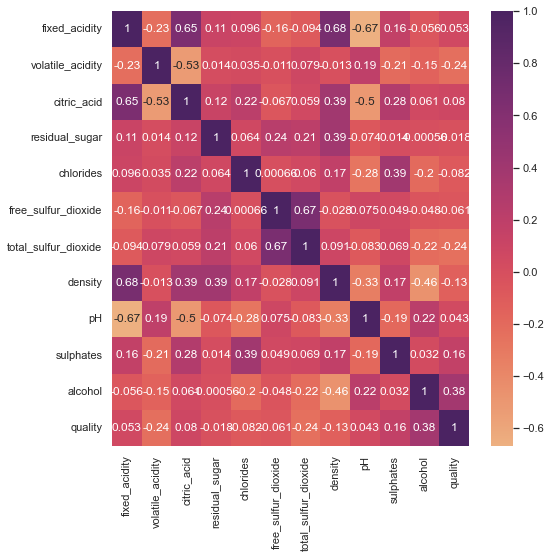

In [52]:
sns.set(font_scale=1)
plt.subplots(figsize=(8,8))
sns.heatmap(corr, cmap= 'flare', annot = True)
plt.show()

This is a heatmap of **feature colinearity** containing values between -1 (directly negatively correlated, 0 (not correlated) and 1 (directly correlated). High feature correlation can introduce noise to a dataset. When we have features that are highly correlated, we have a number of options:

1. Change them
2. Combine them
3. Remove them

Moderate correlation starts to appear at values of 0.6~, so as we can see, we have a number of moderately correlated features. Fixed acidity is moderately correlated to 3 other features, ```citric_acid```, ```density``` and ```pH```.

Let's remove ```fixed_acidity``` and see if it has any bearing on our accuracy.

In [53]:
data_exp_df = main_df.drop(['fixed_acidity'], axis=1)

In [54]:
model_draft(data_exp_df, 0.3 , 100)

Classification Models:
Logistic Regression
0.71397616468039 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.685807150595883 0.7424242424242424
Accuracy score: 74.24% 

Decision Tree Classifier
1.0 0.6616161616161617
Accuracy score: 66.16% 

Random Forest Classifier
0.9859154929577465 0.7676767676767676
Accuracy score: 76.77% 

Gradient Boosting Classifier
0.7258938244853738 0.7550505050505051
Accuracy score: 75.51% 

Support Vector Classifier
0.752979414951246 0.7550505050505051
Accuracy score: 75.51% 

Bagging Classifier
0.9772481040086674 0.7752525252525253
Accuracy score: 77.53% 

Models using K-Fold Cross Validation:
Decision Tree Classifier
[0.43939394 0.40151515 0.52651515 0.46590909 0.48669202] 

Random Forest Classifier
[0.45075758 0.44318182 0.48484848 0.36742424 0.47528517] 

Clustering models: 
K-Nearest Neighbour Classifier Model Score: (0.7345612134344529, 0.7247474747474747)


Doesn't appear to have helped. Let's explore some more graphs:

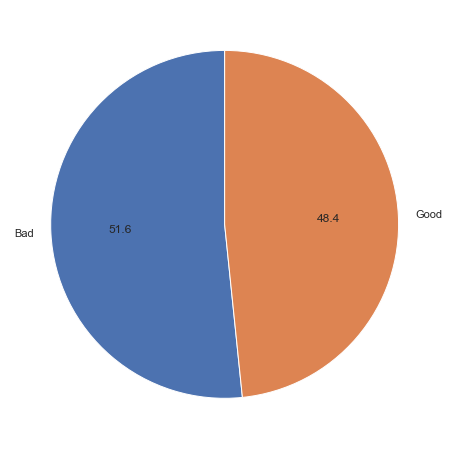

In [55]:
plt.figure(figsize = (8,8))
plt.pie(main_df['quality'].value_counts(), startangle = 90, autopct = '%.1f', labels = ['Bad', 'Good'], shadow = False)
plt.show()

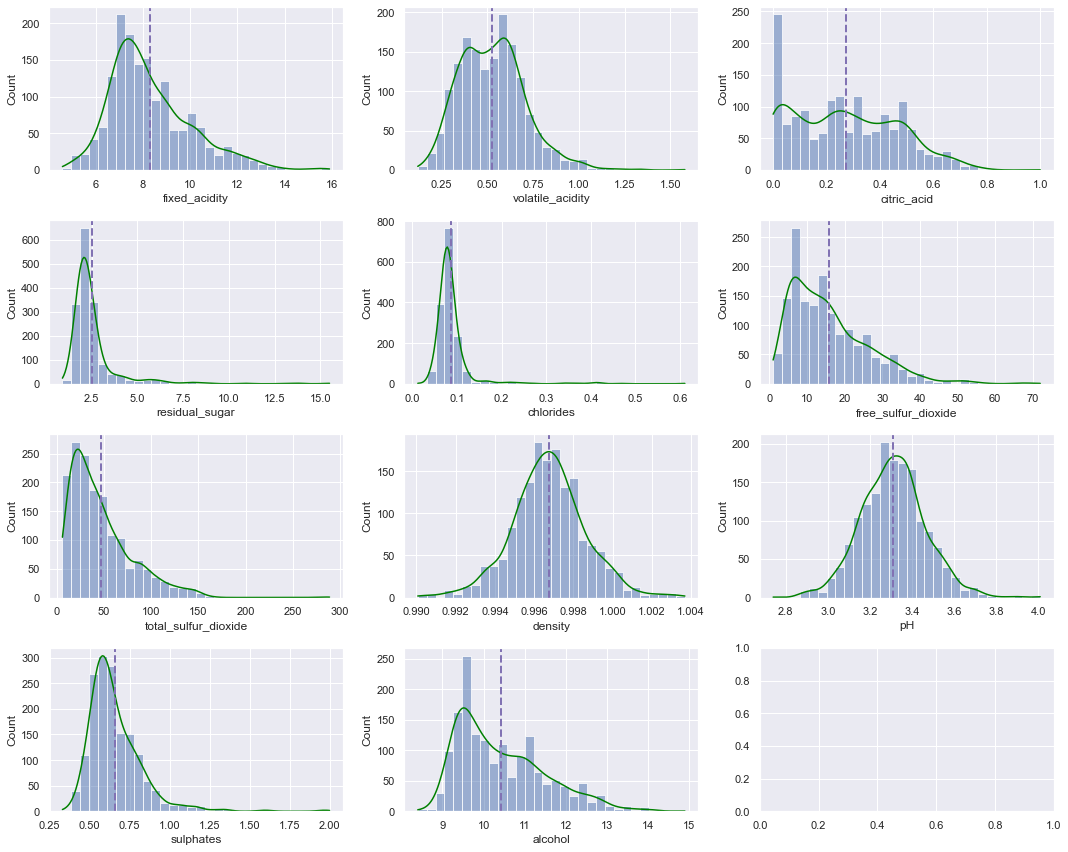

In [56]:
numeric_cols = main_df.drop(columns=['quality']).columns

fig, ax = plt.subplots(4, 3, figsize=(15, 12))
for variable, subplot in zip(numeric_cols, ax.flatten()):
    g=sns.histplot(wine[variable],bins=30, kde=True, ax=subplot)
    g.lines[0].set_color('green')
    g.axvline(x=wine[variable].mean(), color='m', label='Mean', linestyle='--', linewidth=2)
plt.tight_layout()

### Conclusion

In this notebook I have taken a dataset for wines and attempted to predict whether a wine is good or bad according to its other properties.

First I imported the data from a csv to a pandas DataFrame. I then previewed it and checked for null values. Then I scaled it. I then decided I wanted to draft a few models to see how the raw data performed, so I factorised model creation and printing rough approximations of their results. 

When I had a baseline I explored data engineering techniques to improve model accuracy. I tried rounding every wine quality to values representing 'good' or 'bad'. When this did not affect model accuracy I removed all rows containing a quality value that did not fall into our two main qualities [5 and 6.] I did this because 5's and 6's both had around 600 members, whereas the next biggest was 7's, with 200. As a result I figured the data was skewed heavily towards these two groups, so decided to use them only.

I tried different feature selection techniques [low variance filter, variance inflation factor, colinearity], removed outliers [implementing sigma 3 rule] and general rules of thumb [removing duplicates].

After this I took our best dataset and we created several visualisations of our data and its colinearity and feature value distribution. 

Looking back I would have liked to have explored this dataset more, but spent a good amount of time on it and figured I'd rather try a different dataset or model [like an image classifier.] My best accuracy score was 77%. I know accuracy score is a very general metric, but it is very interpretable by humans, and I have read that 70 - 80% is an industry norm. So we're all good!

The biggest difference to accuracy was data selection by representation. That is to say, we only used rows with the most well-represented 'quality' values [5 and 6 respectively]. This made our accuracy score jump from 63.5% to 77%. That took our model from being kind of meh to actually not bad. It's just a shame that our feature engineering and outlier removal did not go so well!